# 六、 GraphSAGE-节点分类
- 图采样聚合网络（​Graph Sample and Aggregate​, GraphSAGE） 
- 是一种创新的图神经网络，其核心是“采样-聚合”的归纳式学习框架。
- 它通过学习一个聚合函数，利用节点自身及其邻居的特征来生成节点嵌入。
- 关键创新在于通过随机采样固定数量的邻居，使算法能高效处理大规模图。
- 这种归纳式设计使其能为训练时未见过的新节点快速生成嵌入，而无需重新训练模型。

Number of nodes: 2708
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
GraphSAGE(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)
Epoch: 010, Loss: 0.4163, Train: 1.0000, Val: 0.7620, Test: 0.7670
Epoch: 020, Loss: 0.0538, Train: 1.0000, Val: 0.7460, Test: 0.7710
Epoch: 030, Loss: 0.0264, Train: 1.0000, Val: 0.7520, Test: 0.7740
Epoch: 040, Loss: 0.0121, Train: 1.0000, Val: 0.7480, Test: 0.7790
Epoch: 050, Loss: 0.0130, Train: 1.0000, Val: 0.7500, Test: 0.7770
Epoch: 060, Loss: 0.0136, Train: 1.0000, Val: 0.7560, Test: 0.7840
Epoch: 070, Loss: 0.0167, Train: 1.0000, Val: 0.7580, Test: 0.7950
Epoch: 080, Loss: 0.0321, Train: 1.0000, Val: 0.7640, Test: 0.7930
Epoch: 090, Loss: 0.0290, Train: 1.0000, Val: 0.7640, Test: 0.7920
Epoch: 100, Loss: 0.0188, Train: 1.0000, Val: 0.7660, Test: 0.8000
Epoch: 110, Loss: 0.0159, Train: 1.0000, Val: 0.7540, Test: 0.7910
Epoch: 120, Loss: 0.0184, Train: 1.0000, Val: 0.7540, Test: 

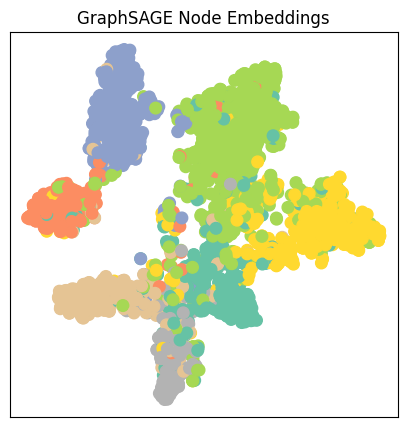

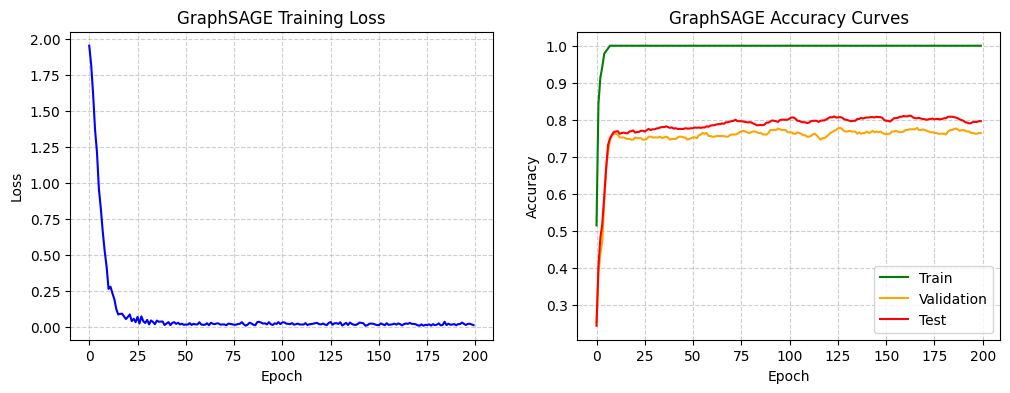


=== GraphSAGE Final Results ===
Best Validation Accuracy: 0.7780
Final Train Accuracy: 1.0000
Final Validation Accuracy: 0.7640
Final Test Accuracy: 0.7960


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv  # GraphSAGE层
from torch_geometric.datasets import Planetoid  # 加载数据集
import matplotlib.pyplot as plt  # 可视化
from sklearn.manifold import TSNE  # 降维

# 加载Cora数据集
dataset = Planetoid(root='../datasets', name='Cora')
data = dataset[0]

# 检查掩码是否正确加载
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Number of validation nodes: {data.val_mask.sum()}")
print(f"Number of test nodes: {data.test_mask.sum()}")


# GraphSAGE模型
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(12345)
        # 使用两层的SAGEConv，第一层输出hidden_channels维特征
        self.conv1 = SAGEConv(num_features, hidden_channels)
        # 第二层直接输出类别数，对应最后的分类结果
        self.conv2 = SAGEConv(hidden_channels, num_classes)
        # GraphSAGE允许自定义聚合函数，默认使用mean
        # 可选：'mean', 'max', 'lstm', 'pool'

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


# 初始化模型，隐藏层维度设为16
model = GraphSAGE(num_features=dataset.num_features,
                 hidden_channels=16,
                 num_classes=dataset.num_classes)
print(model)

# 设置损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# 训练函数
def train():
    model.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清空梯度
    out = model(data.x, data.edge_index)  # 前向传播，计算输出
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # 计算损失
    loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新参数
    return loss.item()


# 测试函数
def test():
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        out = model(data.x, data.edge_index)  # 前向传播，计算输出
        results = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            pred = out.argmax(dim=1)  # 选择概率最大的类别作为预测结果
            acc = pred[mask].eq(data.y[mask]).float().mean().item()
            results.append(acc)
    return results


# 训练过程记录
train_losses = []
train_accs = []
val_accs = []
test_accs = []
best_val_acc = 0
best_model_state = None

# 迭代训练
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    # 记录指标
    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(model.state_dict(), 'output/06-graphsage-node.pth')
    
    # 打印训练信息
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


# 降维可视化函数
def visualize(h, color, epoch=None, save=False):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.title("GraphSAGE Node Embeddings")
    plt.show()


# 分类结果可视化
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

# 训练曲线可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GraphSAGE Training Loss')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train', color='green')
plt.plot(val_accs, label='Validation', color='orange')
plt.plot(test_accs, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GraphSAGE Accuracy Curves')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 最终评估
model.load_state_dict(best_model_state)
final_train, final_val, final_test = test()

print('\n=== GraphSAGE Final Results ===')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Final Train Accuracy: {final_train:.4f}')
print(f'Final Validation Accuracy: {final_val:.4f}')
print(f'Final Test Accuracy: {final_test:.4f}')